IMPORT LIBRARY

In [43]:
# 1️⃣ Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import pickle

# **Load Data**

In [44]:
# 2️⃣ Load Dataset
df_tsunami = pd.read_csv("dataset/earthquake_data_tsunami.csv", header=0)
# print("Jumlah data:", df_tsunami.shape)
df_tsunami.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


In [45]:
print("Jumlah baris, kolom :", df_tsunami.info)
print("\nTipe Data : ")
print(df_tsunami.dtypes)

Jumlah baris, kolom : <bound method DataFrame.info of      magnitude  cdi  mmi  sig  nst   dmin   gap    depth  latitude  longitude  \
0          7.0    8    7  768  117  0.509  17.0   14.000   -9.7963    159.596   
1          6.9    4    4  735   99  2.229  34.0   25.000   -4.9559    100.738   
2          7.0    3    3  755  147  3.125  18.0  579.000  -20.0508   -178.346   
3          7.3    5    5  833  149  1.865  21.0   37.000  -19.2918   -172.129   
4          6.6    0    2  670  131  4.998  27.0  624.464  -25.5948    178.278   
..         ...  ...  ...  ...  ...    ...   ...      ...       ...        ...   
777        7.7    0    8  912  427  0.000   0.0   60.000   13.0490    -88.660   
778        6.9    5    7  745    0  0.000   0.0   36.400   56.7744   -153.281   
779        7.1    0    7  776  372  0.000   0.0  103.000  -14.9280    167.170   
780        6.8    0    5  711   64  0.000   0.0   33.000    6.6310    126.899   
781        7.5    0    7  865  324  0.000   0.0   33.00

# **Pembersihan Data**

# Menangani Data duplikat dan Missing Value

In [ ]:
print("Jumlah nilai kosong per Kolom:\n", df_tsunami.isnull().sum())



Jumlah nilai kosong per Kolom:
 magnitude    0
cdi          0
mmi          0
sig          0
nst          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64


Jumlah duplikat: 0
Bentuk data sebelum/sesudah hapus duplikat: (782, 13) -> (782, 13)


/var/folders/7b/fkg9tk2j3fnd9j30kllh7bmr0000gp/T/ipykernel_49247/1074747789.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_tsunami['magnitude'], df_tsunami['depth'], df_tsunami['sig'], df_tsunami['mmi'], df_tsunami['cdi']],


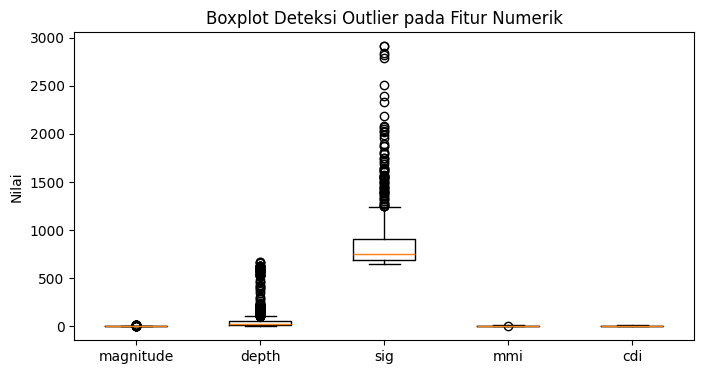

In [47]:
# Hapus duplikat 
print("Jumlah duplikat:", df_tsunami.duplicated().sum())
before = df_tsunami.shape
df_tsunami = df_tsunami.drop_duplicates(keep='first')
print("Bentuk data sebelum/sesudah hapus duplikat:", before, "->", df_tsunami.shape)

# Menampilkan Data Outlier
plt.figure(figsize=(8,4))
plt.boxplot([df_tsunami['magnitude'], df_tsunami['depth'], df_tsunami['sig'], df_tsunami['mmi'], df_tsunami['cdi']],
            labels=['magnitude','depth','sig','mmi','cdi'])
plt.title("Boxplot Deteksi Outlier pada Fitur Numerik")
plt.ylabel("Nilai")
plt.show()

# **Pisahkan Fitur & Target**

In [48]:
features = ['magnitude', 'depth', 'latitude', 'longitude', 'sig', 'mmi', 'cdi']
target = 'tsunami'
X = df_tsunami[features]
y = df_tsunami[target]

# **Train Test Split**

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=98, stratify=y
)
print("Ukuran X_train, X_test :", X_train.shape, X_test.shape)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=98)

Ukuran X_train, X_test : (625, 7) (157, 7)


**Membangun Model Gradient Boosting Classifier dengan pipeline**

In [50]:
pipe_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_classif)),
    ('clf', GradientBoostingClassifier(random_state=21))
])

param_grid_gb = [
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'selector': [SelectKBest(score_func=mutual_info_classif)],
        'selector__k': [3, 5, 'all'],
        'clf__n_estimators': [100, 150],
        'clf__learning_rate': [0.05, 0.1],
        'clf__max_depth': [2, 3]
    },
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'selector': [SelectPercentile(score_func=mutual_info_classif)],
        'selector__percentile': [50, 70, 100],
        'clf__n_estimators': [100, 150],
        'clf__learning_rate': [0.05, 0.1],
        'clf__max_depth': [2, 3]
    }
]


grid_gb = GridSearchCV(
    estimator=pipe_gb,
    param_grid=param_grid_gb,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_gb.fit(X_train, y_train)

print("\n🔹 Best Parameters (Gradient Boosting):")
print(grid_gb.best_params_)
print("Best CV Accuracy:", grid_gb.best_score_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits

🔹 Best Parameters (Gradient Boosting):
{'clf__learning_rate': 0.1, 'clf__max_depth': 2, 'clf__n_estimators': 150, 'scaler': StandardScaler(), 'selector': SelectKBest(score_func=<function mutual_info_classif at 0x1306f87c0>), 'selector__k': 'all'}
Best CV Accuracy: 0.7327999999999999


Support Vector Machine

In [51]:
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_classif)),
    ('clf', SVC())
])

param_grid_svm = [
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'selector': [SelectKBest(score_func=mutual_info_classif)],
        'selector__k': [3, 5, 'all'],
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf'],
        'clf__gamma': ['scale', 'auto']
    },
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'selector': [SelectPercentile(score_func=mutual_info_classif)],
        'selector__percentile': [50, 70, 100],
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf'],
        'clf__gamma': ['scale', 'auto']
    }
]


grid_svm = GridSearchCV(
    estimator=pipe_svm,
    param_grid=param_grid_svm,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_svm.fit(X_train, y_train)

print("\n🔹 Best Parameters (SVM):")
print(grid_svm.best_params_)
print("Best CV Accuracy:", grid_svm.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits

🔹 Best Parameters (SVM):
{'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf', 'scaler': StandardScaler(), 'selector': SelectKBest(score_func=<function mutual_info_classif at 0x1306f87c0>), 'selector__k': 3}
Best CV Accuracy: 0.7008000000000001


# **Evaluasi**



📊 Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79        96
           1       0.69      0.61      0.64        61

    accuracy                           0.74       157
   macro avg       0.73      0.71      0.72       157
weighted avg       0.74      0.74      0.74       157

Accuracy: 0.7388535031847133

📊 SVM Performance:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        96
           1       0.71      0.67      0.69        61

    accuracy                           0.76       157
   macro avg       0.75      0.75      0.75       157
weighted avg       0.76      0.76      0.76       157

Accuracy: 0.7643312101910829


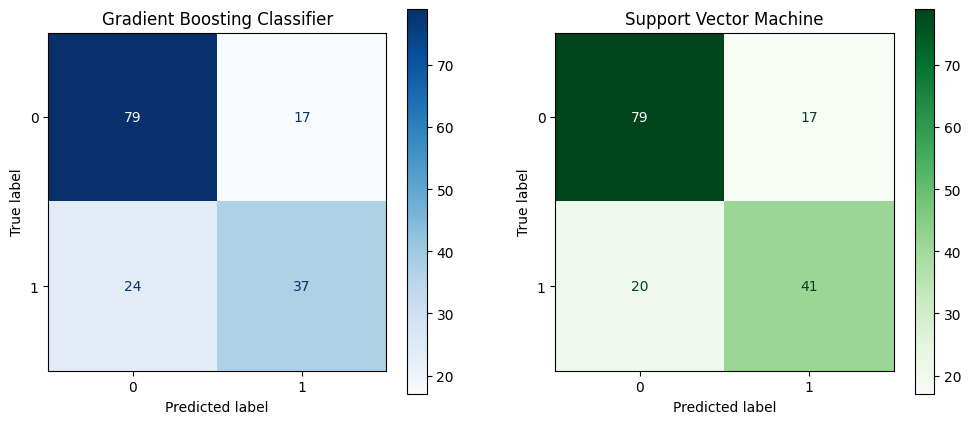

In [52]:
best_gb = grid_gb.best_estimator_
best_svm = grid_svm.best_estimator_

y_pred_gb = best_gb.predict(X_test)
y_pred_svm = best_svm.predict(X_test)

print("\n📊 Gradient Boosting Performance:")
print(classification_report(y_test, y_pred_gb))
print("Accuracy:", accuracy_score(y_test, y_pred_gb))

print("\n📊 SVM Performance:")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))


# Confusion Matrix & Classifitcation Report
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, cmap='Blues', ax=ax[0])
ax[0].set_title("Gradient Boosting Classifier")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, cmap='Greens', ax=ax[1])
ax[1].set_title("Support Vector Machine")
plt.show()

# Visualisasi Perbandingan Model

,Accuracy,Precision,Recall,F1-Score
Gradient Boosting,0.738854,0.685185,0.606557,0.643478
SVM,0.764331,0.706897,0.672131,0.689076


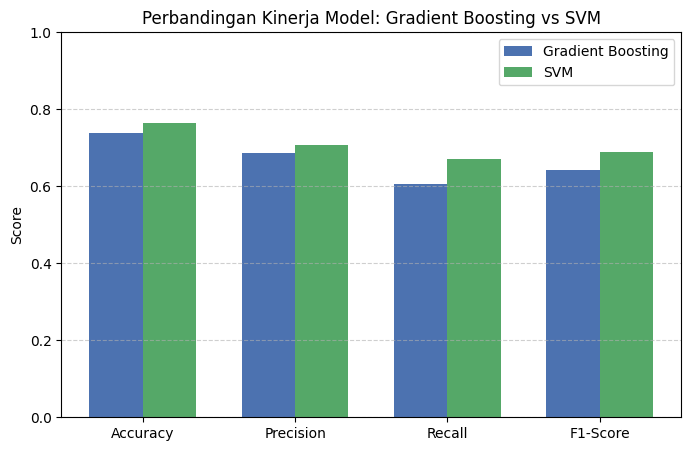

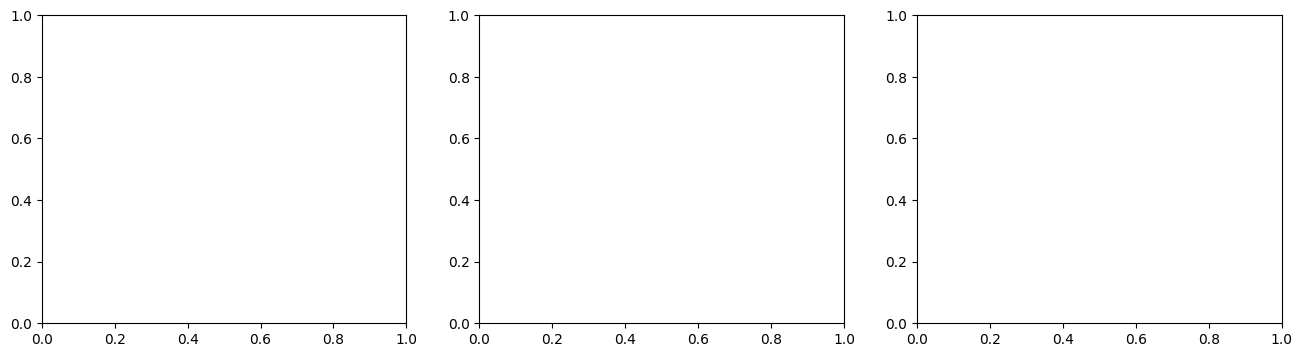

In [53]:
# ==============================================================
# 🔹 Perbandingan Kinerja Model
# ==============================================================

from sklearn.metrics import precision_score, recall_score, f1_score

metrics_gb = {
    "Accuracy": accuracy_score(y_test, y_pred_gb),
    "Precision": precision_score(y_test, y_pred_gb),
    "Recall": recall_score(y_test, y_pred_gb),
    "F1-Score": f1_score(y_test, y_pred_gb)
}

metrics_svm = {
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "Precision": precision_score(y_test, y_pred_svm),
    "Recall": recall_score(y_test, y_pred_svm),
    "F1-Score": f1_score(y_test, y_pred_svm)
}

df_compare = pd.DataFrame([metrics_gb, metrics_svm], index=["Gradient Boosting", "SVM"])
display(df_compare)

plt.figure(figsize=(8,5))
x = np.arange(len(df_compare.columns))
width = 0.35
plt.bar(x - width/2, df_compare.loc["Gradient Boosting"], width, label="Gradient Boosting", color="#4C72B0")
plt.bar(x + width/2, df_compare.loc["SVM"], width, label="SVM", color="#55A868")
plt.xticks(x, df_compare.columns)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Perbandingan Kinerja Model: Gradient Boosting vs SVM")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))

**Feature dengan score tertinggi**

In [54]:
selector_gb = grid_gb.best_estimator_.named_steps['selector']
selector_svm = grid_svm.best_estimator_.named_steps['selector']

feature_scores_gb = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector_gb.scores_
}).sort_values(by='Score', ascending=False)

feature_scores_svm = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector_svm.scores_
}).sort_values(by='Score', ascending=False)

print("\n📈 Feature Importance (GBC):")
print(feature_scores_gb)

print("\n📈 Feature Importance (SVM):")
print(feature_scores_svm)


📈 Feature Importance (GBC):
     Feature     Score
3  longitude  0.180868
2   latitude  0.081904
6        cdi  0.047114
4        sig  0.040214
5        mmi  0.027972
0  magnitude  0.019633
1      depth  0.003674

📈 Feature Importance (SVM):
     Feature     Score
3  longitude  0.181535
2   latitude  0.081904
6        cdi  0.031750
5        mmi  0.027573
1      depth  0.009910
0  magnitude  0.000000
4        sig  0.000000


# **Model Terbaik**

In [55]:
acc_gb = accuracy_score(y_test, y_pred_gb)
acc_svm = accuracy_score(y_test, y_pred_svm)

if acc_gb >= acc_svm:
    best_model = best_gb
    best_name = "GradientBoosting"
else:
    best_model = best_svm
    best_name = "SVM"

with open(f"BestModel_CLF_{best_name}_KelompokTsunami.pkl", "wb") as f:
    pickle.dump(best_model, f)

print(f"\n✅ Model terbaik: {best_name}")
print(f"✅ File tersimpan sebagai: BestModel_CLF_{best_name}_KelompokTsunami.pkl")


✅ Model terbaik: SVM
✅ File tersimpan sebagai: BestModel_CLF_SVM_KelompokTsunami.pkl
